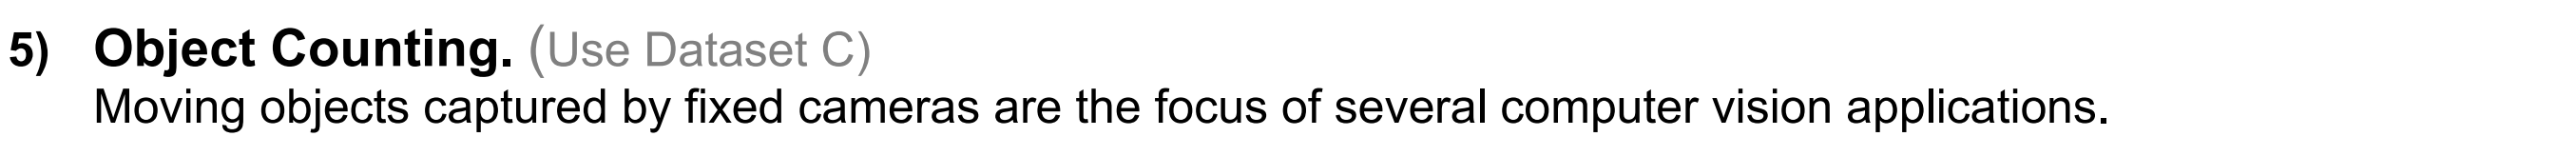

In [ ]:
# import required packages (PIL and Image are ONLY used to read and show images)
import numpy as np
from PIL import Image
import math
import matplotlib.pyplot as plt
import os

In [ ]:
import cv2

# read the video for the given path
video_capture = cv2.VideoCapture('Dataset//DatasetC.avi') 

# check if there is an error in opening video
if not video_capture.isOpened():
    print("Error: Could not open video file.")
    exit()

#iterate through frames of the video and append grayscale frames in a list

frames = []
while True:
    # read a frame
    ret, frame = video_capture.read()
    # check if it is the end of the video and break
    if not ret:
        break  
    # convert frame into grayscale
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # add it into the list
    frames.append(gray_image)
    
video_capture.release()
cv2.destroyAllWindows()

In [ ]:
# this function is to plot each frame, reference frame, frame difference, and thresholded frame difference
# and save the result into given folder name
def plot_frames(reference_frame, current_frame, none_thresholded_diff ,frame_diff, folder_name, frame_number):
    plt.figure(figsize=(10, 6))

    plt.subplot(141)
    plt.imshow(current_frame, cmap='gray')
    plt.title('Current Frame')

    plt.subplot(142)
    plt.imshow(reference_frame, cmap='gray')
    plt.title('Reference Frame')
    
    plt.subplot(143)
    plt.imshow(none_thresholded_diff, cmap='gray')
    plt.title('Difference')
    
    plt.subplot(144)
    plt.imshow(frame_diff, cmap='gray')
    plt.title('Thresholded Difference')
    plt.tight_layout()
    
    directory = "Object counting/"+folder_name
    if not os.path.exists(directory):
        # If not, create the directory
        os.makedirs(directory)
    plt.savefig("Object counting/"+folder_name+"/frame_"+frame_number+".png")

    plt.show()

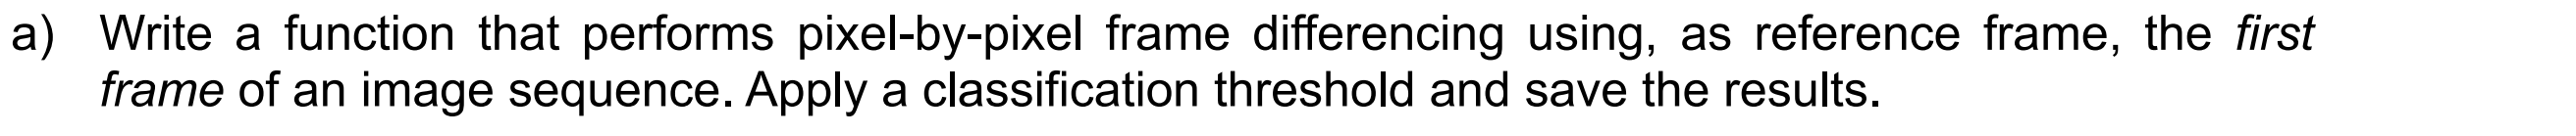

In [ ]:
# calculates absolute and thresholded difference of all frames from the given reference frame 
def frame_difference(all_frames, refrence_frame, threshold = 30):
    # define lists to store absolute and thresholded differences
    differences = []
    none_thresholded_dfifferences = []
#     refrence_frame = all_frames[0]
    
    # iterate through each frame
    for frame in all_frames:
        # calculate the absolute difference of frame from reference frame and cast elements to avoid overflow
        frame_differences = np.abs(frame.astype(np.float32) - refrence_frame.astype(np.float32)).astype(np.uint8)
        # store it
        none_thresholded_dfifferences.append(frame_differences)
        # apply threshold value on each pixel of absolute frame differences to separate background and foreground
        thresholded_frame = np.zeros_like(frame_differences)
        thresholded_frame[frame_differences >= threshold] = 255
        # store thresholded differences
        differences.append(thresholded_frame)
    
    # plot each frame, reference frame, frame difference, and thresholded frame difference and save the figure
    for i in range(len(all_frames)):
        plot_frames(refrence_frame,all_frames[i], none_thresholded_dfifferences[i], differences[i], "a", str(i))
    return differences

In [ ]:
# calculate frame differences from the first frame as a reference frame
frame_difference(frames, frames[0])

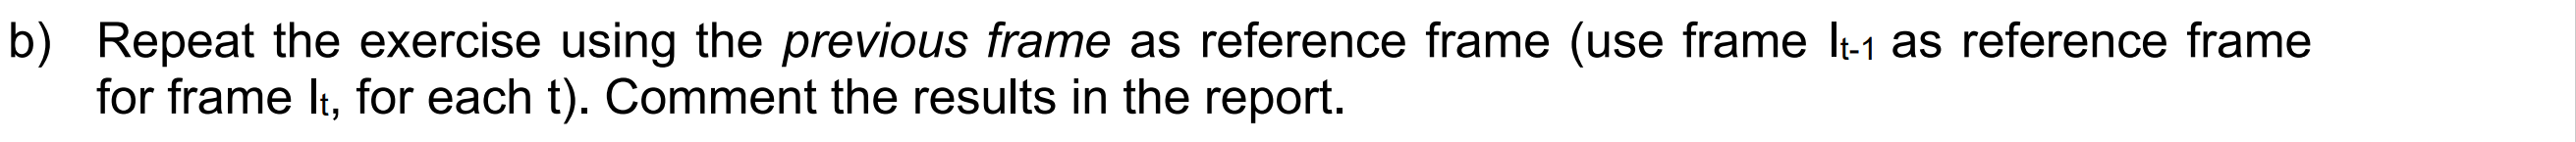

In [ ]:
# calculates absolute and thresholded difference of every two consecutive frames
def consecutive_frame_difference(all_frames, threshold = 30):
    
    # define lists to store absolute and thresholded differences
    differences = []
    none_thresholded_dfifferences = []
    
    # iterate through each frame
    for i in range(1,len(all_frames)):
        
        # calculate the absolute difference of two consecutive frames and cast elements to avoid overflow
        frame_differences = np.abs(all_frames[i].astype(np.float32) - all_frames[i-1].astype(np.float32)).astype(np.uint8)
        # store it
        none_thresholded_dfifferences.append(frame_differences)
        # apply threshold value on each pixel of absolute frame differences to separate background and foreground
        thresholded_frame = np.zeros_like(frame_differences)
        thresholded_frame[frame_differences >= threshold] = 255
         # store thresholded differences
        differences.append(thresholded_frame)
    # plot each frame, reference frame, frame difference, and thresholded frame difference and save the figure
    for i in range(1,len(all_frames)):
        plot_frames(all_frames[i-1],all_frames[i], none_thresholded_dfifferences[i-1], differences[i-1], "b", str(i-1))
    
    
consecutive_frame_difference(frames)

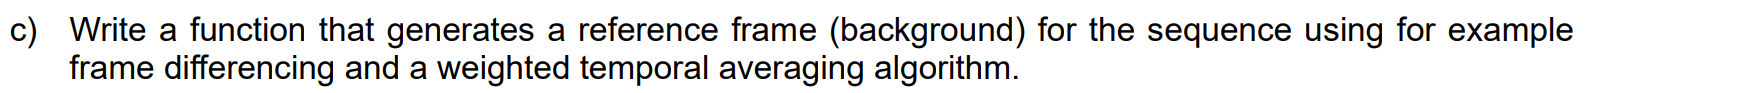

In [ ]:
# generates reference frame (background) from all frames of the video for the given hyperparameter alpha
def generate_refrence_frame(all_frames, alpha):
    # we first assume that the first frame is our reference
    reference_frame = all_frames[0]
    
    # iterate through all frames
    for frame in all_frames:
        
        # calculated the weighted sum of current reference frame and current frame to calculate new reference frame
        reference_frame = (alpha * frame + (1 - alpha) * reference_frame)
                
    # plot and return background
    plt.imshow(reference_frame, cmap = 'gray')
    return reference_frame

# find the best background by adjusting alpha hyperparameter
background = generate_refrence_frame(frames, 0.027)

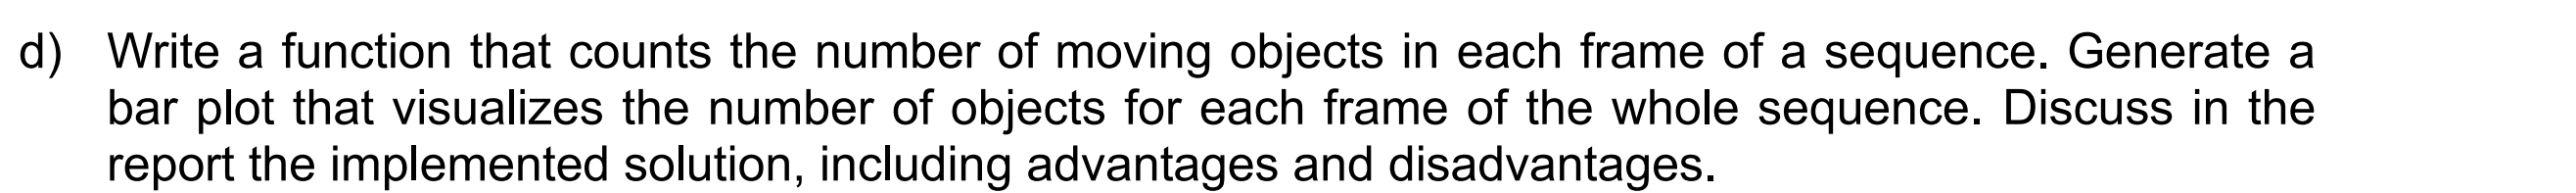

In [ ]:
# calculate the frame differences from the genreated background in the previous step
objects_frames = frame_difference(frames, background, threshold = 30)

In [ ]:
# iterate through image and whitens neighbours of a white pixel for interval of kernel size
def dilate(image, kernel):
    # create output black grid
    output = np.zeros_like(image)
    # iterate through image pixels
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # if a pixel value is white
            if image[i, j] == 255:
                # whitens its neighbours pixels for interval of kernel size from that pixel in the output grid
                output[i:i + kernel.shape[0], j:j + kernel.shape[1]] = 255

    return output

In [ ]:
# define squere kernel for dilate 
dilate_kernel = np.ones((10, 10), np.uint8)
# test the dilate function on the first frame
dilated_frame = dilate(objects_frames[0], dilate_kernel)
#plot dilated frame
plt.imshow(dilated_frame, cmap='gray')

In [ ]:
# find white connected objects(contours) in the dilated image and returns them using depth first search algorithm
def get_contours(image):
    
    # create a list to store indexes of each white component
    # each element of this list is array of the indexes of each white connected component objects
    contours = []

    # we iterate through image pixels
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # if pixel value is white
            if image[i, j] == 255:
                # we find its neighbours using depth first search algorithm and append it 
                contours.append(dfs(image, i, j))
    return contours

# finding neighbour white pixels of the given image for one contour(white connected component)
def dfs(image, i, j):
    # create a list to store indexes of the each white object in a connected component
    connected_component = []
    # stack (LIFO queue)
    frontier = [(i, j)]

    #while stack is not empty
    while frontier:
        # pop the first element from the end of the list
        node_i, node_j = frontier.pop()
        #check if the index is in the image and the pixel is white
        if 0 <= node_i < image.shape[0] and 0 <= node_j < image.shape[1] and image[node_i, node_j] == 255:
           # change the value of that pixel to black in order to do not visit this pixel again
            image[node_i, node_j] = 0
            # add its index to connected component list
            connected_component.append((node_i, node_j))
            # find the neighbours indexes of the current node and add them into the stack to repeat this process for them
            frontier.extend([(node_i-1, node_j), (node_i+1, node_j), 
                          (node_i, node_j-1), (node_i, node_j+1)])
    # return the numpy array of the indexes of the objects in a white connected component
    return np.array(connected_component)

# returns number of the objects in a frame 
def count_objects_of_a_frame(frame, threshold = 480):
    # dilate the frame with dilated kernel to whiten its neighbours
    dilate_kernel = np.ones((10, 10), np.uint8)
    dilated_image = dilate(frame, dilate_kernel)
    # find indexes of all objects in all white connected components 
    white_connected_components = get_contours(dilated_image)
    
    # set a counter
    counter = 0
    # for each component in white connected components we check if the number of objects in that component
    # is bigger than threshold, we assume it is one independent object and increase the counter
    for component in white_connected_components:
        
        if len(component) > threshold: 
            
            counter += 1 
    return counter

# counts the number of objects for each frame of the video
def count_objects_of_all_frames(frames, threshold=480):
    
    frames_objects_counters = []
    # apply previous function on each frame of the video and store the counters in the array
    for frame in frames:
        
        frames_objects_counters.append(count_objects_of_a_frame(frame, threshold = threshold))
        
    return frames_objects_counters
    

In [ ]:
# passing the video to the function
frames_objects_counters = count_objects_of_all_frames(objects_frames, threshold=480)

In [ ]:
# bar plot of the number of objects in each frame
plt.bar(np.arange(len(frames_objects_counters)), frames_objects_counters, width=0.5, color='blue')
plt.xlabel('frame')
plt.ylabel('number of objects')
plt.title('Bar Plot of the number of the objects in a video')
plt.show()